In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.stattools import adfuller
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
from statsmodels.tsa.stattools import acf, pacf

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')

In [4]:
df=pd.read_csv("WV_GDP.csv", header=0, parse_dates=[0],index_col=0,date_parser=dateparse)

In [5]:
df['WV_GDP']=df['WV_GDP'].astype('float')

In [6]:
decomposition = seasonal_decompose(df)

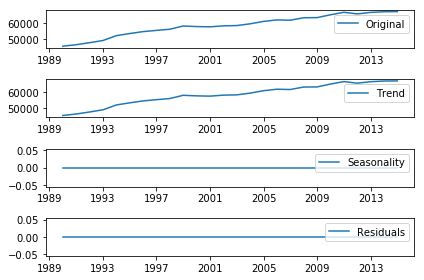

In [7]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.ix[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()


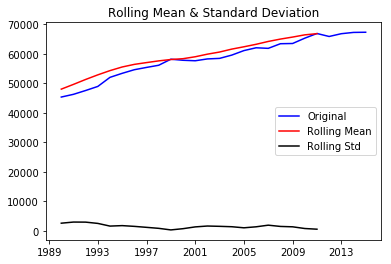

Results of Dickey-Fuller Test:
Test Statistic                  1.531403
p-value                         0.997636
#Lags Used                      0.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [9]:
test_stationarity(df)

In [10]:
df_log=np.log(df)

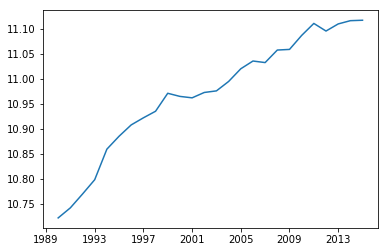

In [11]:
plt.plot(df_log)
plt.show()

In [12]:
#df_log

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()


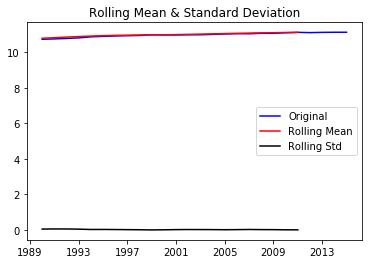

Results of Dickey-Fuller Test:
Test Statistic                  2.229064
p-value                         0.998906
#Lags Used                      0.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [13]:
test_stationarity(df_log)

-34.3657879866


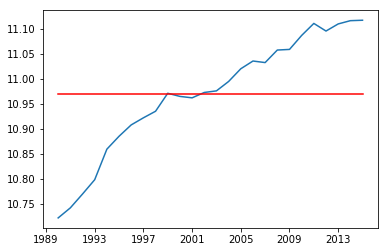

-61.76130723840173


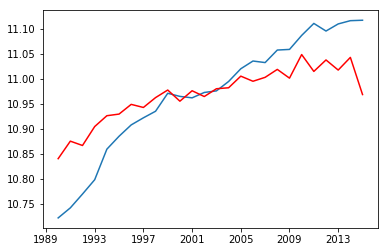

         AIC Modelname
0 -34.365788    (0, 0)
0 -61.761307    (0, 1)
Model selected:
(0, 1)
-61.76130723840173


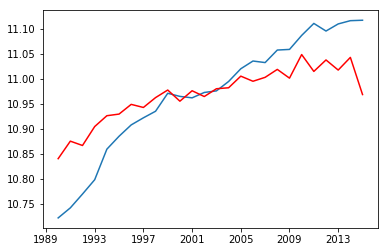

Forecasted values are:
[ 51539.97940208  58013.33035334  58013.33035334  58013.33035334
  58013.33035334]
Predicted existing values are:
2015-01-01    58013.330353
2014-01-01    62481.589701
2013-01-01    60920.154503
2012-01-01    62164.063761
2011-01-01    60755.889755
2010-01-01    62837.575638
2009-01-01    59944.758554
2008-01-01    61000.404859
2007-01-01    60041.694938
2006-01-01    59573.078000
2005-01-01    60184.398720
2004-01-01    58803.312342
2003-01-01    58689.351112
2002-01-01    57783.504129
2001-01-01    58454.087089
2000-01-01    57249.028424
1999-01-01    58537.713422
1998-01-01    57659.733104
1997-01-01    56535.103885
1996-01-01    56884.758234
1995-01-01    55792.047413
1994-01-01    55610.898450
1993-01-01    54421.023688
1992-01-01    52400.749696
1991-01-01    52855.437393
1990-01-01    51038.411196
dtype: float64


In [14]:
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    np.savetxt('ForecastedValues.csv', output, delimiter=",")
    print('Forecasted values are:')
    print(output)
    return output

def FittedValues(model):
    fittedVal=model.fittedvalues
    PredictedVal=np.exp(fittedVal)
    np.savetxt('PredictedValues.csv', PredictedVal, delimiter=",")
    print('Predicted existing values are:')
    return PredictedVal

def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

def AR_Model(ts, param):
    
    model = tsa.ARMA(ts, order=param)
    results_AR = model.fit(disp=0)
    print(results_AR.aic)
    plt.plot(ts)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.show()
    cal_aic_metric(param,results_AR)
    return results_AR

def chooseModel(df_log):
    p = range(0, 1)
    q = range(0,2)
    pq = list(itertools.product(p, q))
    for param in pq:
        results=AR_Model(df_log, param)
    print(aic_metric)
    aic_metric.to_csv('AICMetric.csv', sep=",")
    paramNew=aic_metric['Modelname'][aic_metric['AIC']==aic_metric['AIC'].min()]
    paramNew=paramNew[0]
    print('Model selected:')
    print(paramNew)
    results_AR_final=AR_Model(df_log, paramNew)
    forecast(results_AR_final, 5)
    print(FittedValues(results_AR_final))
    return results_AR_final

aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {}
chooseModel(df_log)

In [15]:
ar_mod=sm.tsa.AR(df_log)

In [16]:
ar_mod=ar_mod.fit(3)

In [17]:
np.exp(ar_mod.predict(4, 4))

2011-01-01    65318.716728
Freq: -1AS-JAN, dtype: float64

In [18]:
ma_mod=sm.tsa.ARMA(df_log, (0,3))

In [19]:
ma_mod=ma_mod.fit()

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [20]:
np.exp(ma_mod.predict(4, 4))

2011-01-01    63601.132268
Freq: -1AS-JAN, dtype: float64

In [21]:
arma_mod=sm.tsa.ARMA(df_log, (0,3))

In [22]:
arma_mod=arma_mod.fit()

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [23]:
np.exp(arma_mod.forecast(steps=2)[0].tolist())

array([ 47029.09693208,  57743.10974189])

In [24]:
start = pd.Timestamp('1990')

In [25]:
end = pd.Timestamp('2015')

In [26]:
df.index=pd.DatetimeIndex(start=start, end=end, freq='AS')

In [27]:
df.index

DatetimeIndex(['1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [28]:
df=pd.read_csv("WV_GDP.csv", header=0, parse_dates=[0],index_col=0,date_parser=dateparse)

In [29]:
df['WV_GDP']=df['WV_GDP'].astype('float')

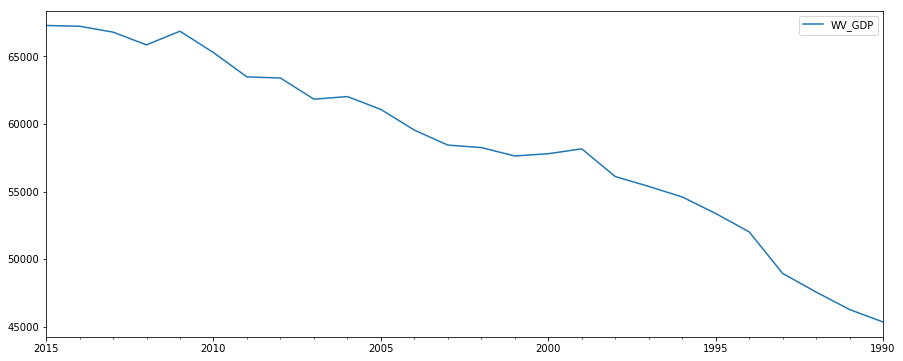

In [30]:
df.plot(figsize=(15, 6))
plt.show()

In [31]:
rolmean = pd.rolling_mean(df, window=5)

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
  if __name__ == '__main__':


In [32]:
rolstd = pd.rolling_std(df, window=5)

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()
  if __name__ == '__main__':


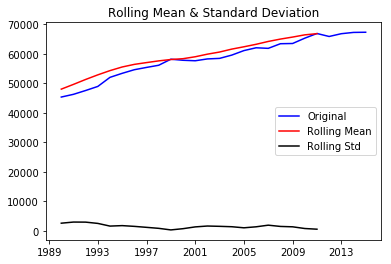

In [33]:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Decomposition 

In [34]:
decomposition = seasonal_decompose(df)

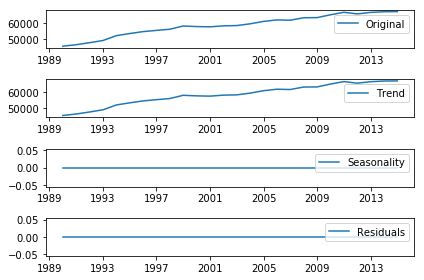

In [35]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Stationarity

predicted=58043.387010, expected=56110.000000
predicted=56025.622475, expected=55378.000000
predicted=54794.280291, expected=54600.000000
predicted=53063.825887, expected=53374.000000
predicted=52459.098335, expected=52016.000000
predicted=50894.331532, expected=48939.000000
predicted=47055.265173, expected=47557.000000
predicted=45468.885367, expected=46263.000000
predicted=43892.361074, expected=45343.000000
AIC: 388.023


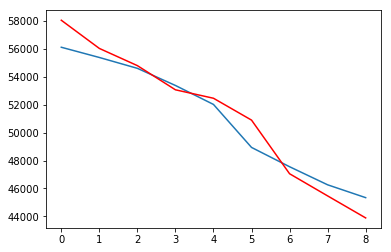

In [36]:
X=df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,2,0))
	model_fit = model.fit(disp=-1)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print('AIC: %.3f' % model_fit.aic)
#error = mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [37]:
model_fit.forecast(steps=2)

(array([ 43892.36107352,  42175.11663828]),
 array([  918.31180632,  1447.59733992]),
 array([[ 42092.50300655,  45692.21914048],
        [ 39337.87798792,  45012.35528864]]))

In [38]:
#df

In [39]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.ix[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()


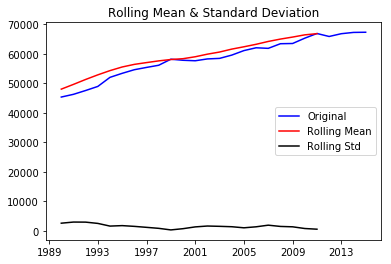

Results of Dickey-Fuller Test:
Test Statistic                  1.531403
p-value                         0.997636
#Lags Used                      0.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [40]:
test_stationarity(df)

In [41]:
df_log=np.log(df)

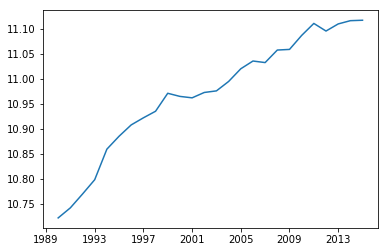

In [42]:
plt.plot(df_log)
plt.show()

In [43]:
#df_log

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()


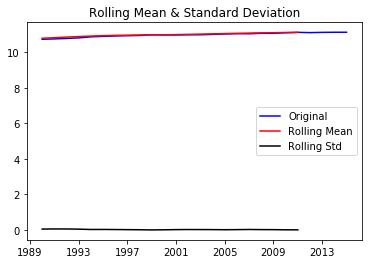

Results of Dickey-Fuller Test:
Test Statistic                  2.229064
p-value                         0.998906
#Lags Used                      0.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [44]:
test_stationarity(df_log)

In [45]:
df_log_shift=df_log-df_log.shift()

In [46]:
df_log_shift.dropna(inplace=True)

C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).mean()
C:\Users\Vaidehi Deshpande\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5).std()


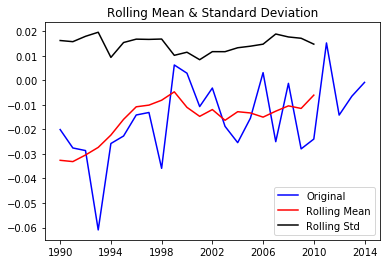

Results of Dickey-Fuller Test:
Test Statistic                 -4.101525
p-value                         0.000963
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (5%)            -2.992216
Critical Value (1%)            -3.737709
Critical Value (10%)           -2.635747
dtype: float64


In [47]:
test_stationarity(df_log_shift)

# Determine p,q from ACF and PACF plots

In [48]:
lag_acf = acf(df_log_shift, nlags=10)
lag_pacf = pacf(df_log_shift, nlags=10, method='ols')

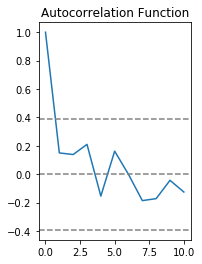

In [49]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

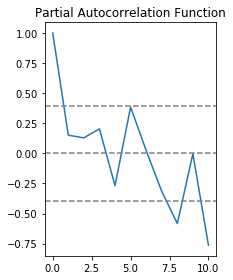

In [50]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# Models

# AR Model

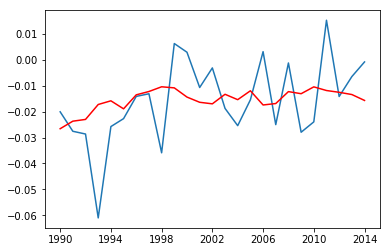

AIC: -128.4770


In [51]:
model = ARIMA(df_log, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
ARAic=results_AR.aic

plt.plot(df_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()
print('AIC: %.4f'% results_AR.aic)
#print('RSS: %.4f'% sum((results_AR.fittedvalues-df_log.ix[:,0])**2))
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log)**2))

In [52]:
result=results_MA.forecast(steps=2)[0]
result.tolist()
result=np.exp(result)
result

NameError: name 'results_MA' is not defined

In [ ]:
#df

# MA Model

In [ ]:
model = MA(df_log, order=(0,  3))  
results_MA = model.fit(disp=-1)
MAAic=results_MA.aic
plt.plot(df_log_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()
print('AIC: %.4f'% results_MA.aic)
print('RSS: %.4f'% sum((results_MA.fittedvalues-df_log_shift.ix[:,0])**2))
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log)**2))

# Combined Model

In [64]:
model = ARIMA(df, order=(3, 0, 3))  
results_ARIMA = model.fit(disp=0)  
ARIMAAic=results_ARIMA.aic

#plt.plot(df_log_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()
print('AIC: %.4f'% results_ARIMA.aic)
#print('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log.ix[:,0])**2))

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [55]:
results_ARIMA.predict(start=4, end=4)

NameError: name 'results_ARIMA' is not defined

In [87]:
np.exp(results_AR.forecast()[0].tolist())
#out

array([ 76874.3916225])

# Choose the Model with low AIC

In [33]:
if (ARAic < MAAic) & (ARAic < ARIMAAic):
    out=results_AR.forecast(steps=10)[0]
    print('AR selected')
elif (MAAic < ARAic) & (MAAic < ARIMAAic):
    out=results_MA.forecast(steps=2)[0]
    print('MA selected')
elif (ARIMAAic < ARAic) & (ARIMAAic < MAAic):
    out=results_ARIMA.forecast(steps=2)[0]
    print('ARIMA selected')
#list(reversed(out))
listOne=out.tolist()
listOne=listOne[::-1]
listOne=np.exp(listOne)
list1=listOne.tolist()
dfList=df.ix[:,0].tolist()
newList=list1+dfList
newList

MA selected


[44069.28953978906,
 44757.56850814559,
 67294.0,
 67236.0,
 66800.0,
 65859.0,
 66868.0,
 65285.0,
 63485.0,
 63405.0,
 61838.0,
 62030.0,
 61079.0,
 59546.0,
 58439.0,
 58254.0,
 57633.0,
 57799.0,
 58160.0,
 56110.0,
 55378.0,
 54600.0,
 53374.0,
 52016.0,
 48939.0,
 47557.0,
 46263.0,
 45343.0]

In [67]:
results_MA.predict('2004-01-01','2005-01-01',dynamic=True)
temp

ValueError: negative dimensions are not allowed

In [55]:
np.exp(temp)

array([ 0.98804286])

In [53]:
temp1=results_MA.forecast()[0]

In [50]:
temp1=temp1.tolist()

In [51]:
np.exp(temp1)

array([ 44757.56850815])

In [167]:
index=df.index

In [175]:
dataframe1=pd.read_csv('DC_UnemploymentRate.csv', header=0)

In [171]:
dataframe1.head()

,Year,DC_UnemploymentRate
Year,,
1977-01-01,1977,9.158333
1978-01-01,1978,8.250000
1979-01-01,1979,7.025000
1980-01-01,1980,7.375000
1981-01-01,1981,8.908333


In [176]:
index_vals = pd.to_datetime(dataframe1.ix[:,0], format='%Y')
dataframe1 = dataframe1.set_index(index_vals)
dataframe1 = dataframe1.sort_index()
dataframe1.drop('Year', axis=1, inplace=True)
    
    # dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    
    
    # dataframe1 = dataframe1.set_index(dataframe1.ix[:,0])
    # dataframe1.drop('Column 0', axis=1, inplace=True)
    # dataframe1 = dataframe1.sort_index()
ts_log = dataframe1.apply(lambda x: np.log(x))
model = ARIMA(ts_log, order=(2, 0, 3))
print(ts_log)
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.fittedvalues)
forcasted_values = np.exp(np.array(results_ARIMA.fittedvalues.values.tolist()))
print(forcasted_values)

            DC_UnemploymentRate
Year                           
1977-01-01             2.214664
1978-01-01             2.110213
1979-01-01             1.949475
1980-01-01             1.998096
1981-01-01             2.186987
1982-01-01             2.345804
1983-01-01             2.415914
1984-01-01             2.213754
1985-01-01             2.096995
1986-01-01             2.019338
1987-01-01             1.845827
1988-01-01             1.616082
1989-01-01             1.590934
1990-01-01             1.835245
1991-01-01             2.047693
1992-01-01             2.149822
1993-01-01             2.143003
1994-01-01             2.075266
1995-01-01             2.171907
1996-01-01             2.132192
1997-01-01             2.080483
1998-01-01             2.131203
1999-01-01             1.851076
2000-01-01             1.724254
2001-01-01             1.845827
2002-01-01             1.857599
2003-01-01             1.921813
2004-01-01             2.051985
2005-01-01             1.852384
2006-01-